## Markov Switching Model from scratch

For references check:
- https://www.stat.cmu.edu/~cshalizi/dst/18/lectures/24/lecture-24.html

In [65]:
from scipy.stats import norm
# from scipy.signal import fftconvolve
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as dc

## Test data preparation

### Simulated problem
Problem parameters
- n_states = 2
- mu_0 = -1
- std_0 = 1
- mu_1 = 1
- std_1 = 0.7
- p00 = 0.8
- p11 = 0.9

In [121]:
ps0_true = np.array([.5,.5])
pss_true = [{0:.8, 1:.2},{0:.15, 1:.85}]
pysparams_true = [(3,1),(-2,.5)]

In [109]:
def pys(state,yi,params):
    """
    state: 0, 1, 2, etc.
    yi: the observation value
    params: vector of parameters needed for the model. E.g. [(mu0,std0),(mu1,std1)]
    """
    return norm.pdf(yi,*params[state])

def gys(state,params):
    return norm.rvs(*params[state])

[0.5 0.5] [{0: 0.8, 1: 0.2}, {0: 0.15, 1: 0.85}] [(3, 1), (-2, 0.5)]


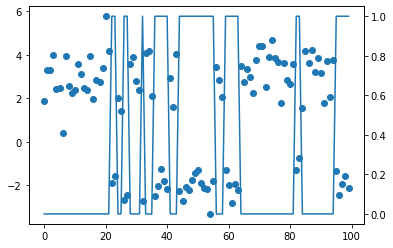

In [122]:
def simulate_data(ps0,pss,pys,pysparams,N,random_state=42):
    np.random.seed(random_state)
    states = np.full(N,np.nan).astype(int)
    y = np.full(N,np.nan)

    n_states = len(ps0)
    ss = np.arange(n_states)

    r = np.random.rand()
    cumprob = 0
    for s in ss:
        cumprob+=ps0[s]
        if r<cumprob:
            states[0] = s
            break
    y[0] = gys(states[0],pysparams)

    for t in range(1,N):
        r = np.random.rand()
        cumprob = 0
        for s in pss[states[t-1]].keys():
            cumprob += pss[states[t-1]][s]
            if r<cumprob:
                states[t] = s
                break
        y[t] = gys(states[t],pysparams)
    return states,y
ps0,pss,pysparams = ps0_true,pss_true,pysparams_true
print(ps0,pss,pysparams)
s_true,y = simulate_data(ps0,pss,pys,pysparams,100)
fig,ax = plt.subplots()
ax.scatter(np.arange(y.shape[0]),y)
ax2 = ax.twinx()
ax2.plot(np.arange(states.shape[0]),states)
fig.show()
    

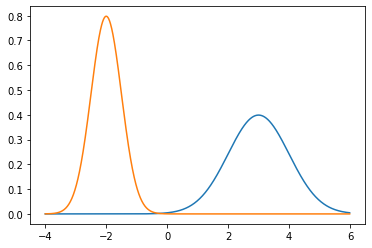

In [118]:
fig,ax = plt.subplots()
x_axis = np.arange(-4,6,0.01)
ax.plot(x_axis,norm.pdf(x_axis,*pysparams[0]))
ax.plot(x_axis,norm.pdf(x_axis,*pysparams[1]))
fig.show()

## Algorithms

### Forward Algorithm

In [77]:
def FA(y,ps0,pys,pysparams,pss):
    """
    y: np.array(observations).astype(int)
    ps0: np.array(initial state probabilities)
    pys: function which returns the probability of a certain y given a certain s
    pysparams: vector of tuples containing the parameters needed for the pys
    pss: vector of dictionaries containing the state transition probabilities
    """
    N = y.shape[0]
    n_states = len(ps0)
    ss = np.arange(n_states)

    alfas = np.full([n_states,N],np.nan)
    gammas = np.full(N,np.nan)
    
    t = 0
    for state in ss:
        alfas[state,t] = ps0[state]*pys(state,y[t],pysparams)/sum(ps0[s]*pys(state,y[t],pysparams) for s in ss)
    gammas[t] = 1
    aux = dc(alfas)
    aux2 = np.full([n_states,N],np.nan)

    for t in range(1,N):
        for state in ss:
            aux[state,t-1] = sum(pss[s][state]*alfas[s,t-1] for s in ss)
            aux2[state,t] = pys(state,y[t],pysparams)*aux[state,t-1]
        gammas[t] = sum(aux2[s,t] for s in ss)
        for state in ss:
            alfas[state,t] = aux2[state,t]/gammas[t]

    p = np.exp(np.sum(np.log(gammas))) # summing logs instead of multiplying probabilities to avoid underflow. Probability of y(0) ignored
    return p,alfas,gammas

### Backwards Algorithm

In [81]:
def BA(y,ps0,pys,pysparams,pss):
    """
    y: np.array(observations).astype(int)
    ps0: np.array(initial state probabilities)
    pys: function which returns the probability of a certain y given a certain s
    pysparams: vector of tuples containing the parameters needed for the pys
    pss: vector of dictionaries containing the state transition probabilities
    """
    N = y.shape[0]
    n_states = len(ps0)
    ss = np.arange(n_states)

    _, _, gammas = FA(y,ps0,pys,pysparams,pss)
    betas = np.full([n_states,N],np.nan)
    for s in ss: betas[s,N-1] = 1

    for t in range(N-1,0,-1):
        for state in ss:
            betas[state,t-1] = sum(betas[s,t]*pys(state,y[t],pysparams)*pss[state][s]/gammas[t] for s in ss)
    
    return betas

### Viterbi Algorithm

In [128]:
def VA(y,pys,pysparams,pss):
    """
    y: np.array(observations).astype(int)
    pys: function which returns the probability of a certain y given a certain s
    pysparams: vector of tuples containing the parameters needed for the pys
    pss: vector of dictionaries containing the state transition probabilities
    """
    N = y.shape[0]
    n_states = len(pss)
    ss = np.arange(n_states)
    v = np.full([n_states,N],np.nan)
    w = np.full([n_states,n_states,N],np.nan)
    B = np.full([n_states,N],np.nan)

    for s in ss:
        v[s,0] = pys(s,y[0],pysparams)

    for t in range(1,N):
        for s_new in ss:
            best = -np.Inf
            best_s = np.nan
            for s_old in ss:
                w[s_old,s_new,t] = v[s_old,t-1] + np.log(pss[s_old][s_new]) + np.log(pys(s_new,y[t],pysparams))
                if w[s_old,s_new,t] > best: 
                    best = w[s_old,s_new,t]
                    best_s = s_old
            
            B[s_new,t] = best_s
            v[s_new,t] = w[best_s,s_new,t]
    s_opt = np.full(N,np.nan).astype(int)
    s_opt[t] = np.argmax(v[:,-1])
    for t in range(N-2,-1,-1):
        s_opt[t] = B[s_opt[t+1],t+1]
    return s_opt

def viterbi_accuracy(s_true,s_predicted,plot=False):
    if s_true.shape[0] == s_predicted.shape[0]:
        N = s_true.shape[0]
    else:
        raise ValueError("Both state vectors must be of the same length")
    right = 0
    for i in range(N):
        if s_true[i] == s_predicted[i]: right += 1
    
    if plot:
        fig,ax = plt.subplots()
        ax.plot(s_predicted)
        ax.plot(s_true)
        fig.show()
    
    return right/N

1.0


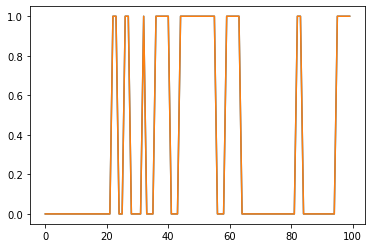

In [123]:
s_predicted = VA(y,pys,pysparams,pss)
print(viterbi_accuracy(s_true,s_predicted))
fig,ax = plt.subplots()
ax.plot(s_predicted)
ax.plot(s_true)

### Gibbs sampling

In [102]:
pss0 = [{0: .8, 1: .2},{0: .1, 1: .9}]
pysparams0 =[(1,.5),(-1,1)]
n_states = len(pss0)
ss = np.arange(n_states)
N = y.shape[0]

pss = pss0
pysparams = pysparams0

In [60]:

# First, we run VA on guessed parameters
s_guess = VA(y,pys,pysparams,pss)
y_subs = [np.array(np.nan) for s in ss]
print(viterbi_accuracy(s_true,s_guess))
# New pys parameters estimation
for s in ss:
    y_subs[s] = y[s_guess==s]
    pysparams[s] = norm.fit(y_subs[s])
print(pysparams)


0.65
[(nan, nan), (0.4158028499813144, 1.4187946200054433)]


/home/fcelaya/quant/venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:366: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/home/fcelaya/quant/venv/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fcelaya/quant/venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:371: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())


In [130]:
def BWA_GS(y,ps00,pss0,pys,pysparams0,n_iter,n_talk=50):
    n_states = len(ps00)
    ss = np.arange(n_states)
    N = y.shape[0]

    ps0 = ps00
    pss = pss0
    pysparams = pysparams0

    for iter in range(n_iter):
        prob, alfas, gammas = FA(y,ps0,pys,pysparams,pss)
        betas = BA(y,ps0,pys,pysparams,pss)
        w = np.multiply(alfas,betas)
        wprima = np.full([n_states,n_states,N-1],np.nan)
        for t in range(N-1):
            for s_old in ss:
                for s_new in ss:
                    wprima[s_old,s_new,t] = alfas[s_old,t]*pss[s_old][s_new]*pys(s_new,y[t],pysparams)*betas[s_new,t+1]/gammas[t+1]

        for s_old in ss:
            ps0[s_old] = w[s_old,1]
            for s_new in ss:
                pss[s_old][s_new] = sum(wprima[s_old,s_new,t] for t in range(N-1))/sum(wprima[s_old,s,t] for s in ss for t in range(N-1))
        
        # pysparams estimation
        s_guess = VA(y,pys,pysparams,pss)
        y_subs = [np.array(np.nan) for s in ss]
        for s in ss:
            y_subs[s] = y[s_guess==s]
            pysparams[s] = norm.fit(y_subs[s])

        if iter==0 or iter==1 or iter==2:
            print(pss)
            print(pysparams)

        if (iter+1)%n_talk==0:
            print(f"Completed iterations: {iter+1}/{n_iter}")

    return ps0,pss,pysparams

ps00 = np.full(2,.5)
pss0 = [{0: .8, 1: .2},{0: .1, 1: .9}]
pysparams0 =[(1,.5),(-1,1)]

ps0,pss,pysparams = BWA_GS(y,ps00,pss0,pys,pysparams0,600,n_talk=100)
print(viterbi_accuracy(s_true,VA(y,pys,pysparams,pss)))
print(ps0)
print(pss)
print(pysparams)


[{0: 0.9645692751950282, 1: 0.03543072480497179}, {0: 0.09188524434212247, 1: 0.9081147556578776}]
[(2.52814101270344, 0.8482052129195099), (1.1237855583024614, 2.7165913571690234)]
[{0: 0.9352809946315644, 1: 0.06471900536843617}, {0: 0.048953136695558196, 1: 0.9510468633044415}]
[(3.0829669009439553, 0.874570810056013), (-0.2904466586508041, 2.5465267173367625)]
[{0: 0.9894818781266723, 1: 0.010518121873326715}, {0: 0.030669847426920447, 1: 0.9693301525730796}]
[(3.1895474471954475, 0.9283295843022757), (-0.4644954760941914, 2.3481788234344156)]
Completed iterations: 100/600
Completed iterations: 200/600
Completed iterations: 300/600
Completed iterations: 400/600
Completed iterations: 500/600
Completed iterations: 600/600
0.84
[1.00587531e+00 7.68121090e-07]
[{0: 0.9941462943835533, 1: 0.0058537056164465525}, {0: 0.007783734602786713, 1: 0.9922162653972133}]
[(3.1895474471954475, 0.9283295843022757), (-0.4644954760941914, 2.3481788234344156)]


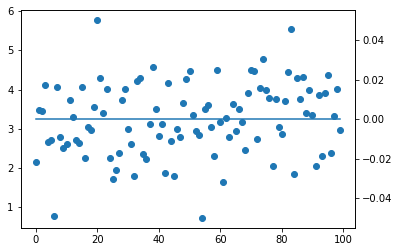

In [135]:
statessim,ysim = simulate_data(ps0,pss,pys,pysparams,100)
fig,ax = plt.subplots()
ax.scatter(np.arange(ysim.shape[0]),ysim)
ax2 = ax.twinx()
ax2.plot(np.arange(statessim.shape[0]),statessim)
fig.show()

0.84


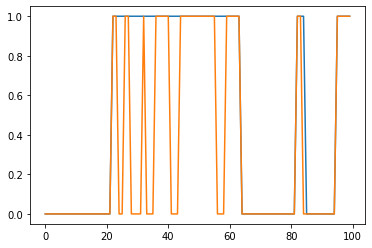

In [132]:
s_predicted = VA(y,pys,pysparams,pss)
print(viterbi_accuracy(s_true,s_predicted,plot=True))